<a href="https://colab.research.google.com/github/kanakesh2006/Langgraph_for_Agentic_AI_Concepts/blob/main/Chatbot/basic_memory_chatbot_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langgraph langchain_google_genai langchain_groq langchain_community langchain_core transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
   

In [9]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
import operator

In [2]:
import os
from google.colab import userdata

# os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')


# using  GROQ's  "llama-3.1-8b-instant"  model
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')


# os.environ['HUGGINGFACE_API_KEY'] = userdata.get('HUGGINGFACE_API_KEY')


In [3]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [5]:
# state

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]


In [6]:
# node functions

def chat_node(state: ChatState):

  # take user query from state
  messages = state['messages']

  # send to llm
  response = model.invoke(messages)

  # response store state
  return { 'messages': [response]}


In [10]:
checkpointer = MemorySaver()

# graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat node', chat_node)

# add edges
graph.add_edge(START, 'chat node')
graph.add_edge('chat node', END)

# compile
chatbot = graph.compile(checkpointer=checkpointer)


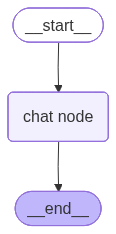

In [11]:
chatbot

In [ ]:
initial_state = {
    'messages': [HumanMessage(content="What is the capital of india")]
}

chatbot.invoke(initial_state)

In [13]:
thread_id = '1'

while True:

  user_message = input('Type Here: ')

  print('User: ', user_message)

  if user_message.strip().lower() in ['exit', 'quit', 'bye']:
    break

  config = {'configurable': {'thread_id': thread_id}}

  response = chatbot.invoke({'messages': [HumanMessage(content=user_message)]}, config=config)

  print('AI:', response['messages'][-1].content)

Type Here: Hi! i am kanakesh
User:  Hi! i am kanakesh
AI: Nice to meet you, Kanakesh. Is there something I can help you with today?
Type Here: do you know my name and how
User:  do you know my name and how
AI: I know your name as "Kanakesh" because you mentioned it at the beginning of our conversation. I store and recall the information you provide, allowing me to address you by name and engage in a more personalized conversation.
Type Here: ok bye
User:  ok bye
AI: It was nice chatting with you, Kanakesh. Have a great day! Bye!
Type Here: exit
User:  exit


In [14]:
chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi! i am kanakesh', additional_kwargs={}, response_metadata={}, id='a6d03037-b2f3-4935-9e46-01c75130def6'), AIMessage(content='Nice to meet you, Kanakesh. Is there something I can help you with today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 42, 'total_tokens': 62, 'completion_time': 0.037283809, 'completion_tokens_details': None, 'prompt_time': 0.017762568, 'prompt_tokens_details': None, 'queue_time': 0.21532875, 'total_time': 0.055046377}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bd169-d3f2-7b51-b8d7-f638010795b1-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 42, 'output_tokens': 20, 'total_tokens': 62}), HumanMessage(content='do you know my name and how', additional_kwargs={}, response_metadata